In [0]:
import string,re,json,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim, pyLDAvis, pyLDAvis.gensim 
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from PIL import Image 
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from pprint import pprint
import spacy
import nltk
import itertools

%matplotlib inline

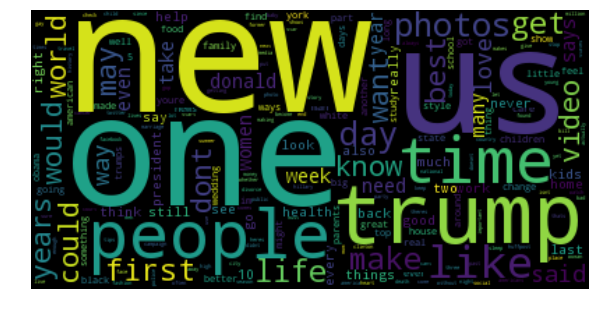

In [33]:
## At this point we have ran the 'ngrams.py' script and created an xlsx workbook 'news_category_ngrams.xlsx' in the 
## current directory
## Create a word cloud using the the ngrams for n = 1 

xl_f = pd.ExcelFile('news_category_ngrams.xlsx')
df = xl_f.parse('Sheet1',header = None)

#create word/count dict to generate word cloud
l = list(zip(df[0],df[1]))
counts = dict(l)
wc = WordCloud().generate_from_frequencies(counts)

plt.figure(figsize = [10,20])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
## Implement LDA and visualize the results, we will cross-validate 
## using log-perplexity to determine the number of topics


#Read in and clean the data. Remove punctuation and lemmatize.
punct_re = "[" + string.punctuation + "]"
stp_wds = [re.sub(punct_re,"",word) for word in stopwords.words('english')]
stp_wds.extend(['-PRON-', " "])
nlp = spacy.load('en',disable=['parser','ner'])
text = []

with open('News_Category_Dataset_v2.json') as f:
    for line in f:
        json_dict = json.loads(line)
        hl = re.sub(punct_re,"",json_dict['headline']).lower()
        sd = re.sub(punct_re,"",json_dict['short_description']).lower()
        doc = nlp(hl + " " + sd)
        tokens = [token.lemma_ for token in doc]
        doc_no_stops = [word for word in tokens if (word not in stp_wds and not word.isnumeric())]
        text.append(doc_no_stops)


In [0]:
#add bigrams to text 
bigram = Phrases(text,min_count = 20,threshold = 50)
for ind in range(len(text)):
    for token in bigram[text[ind]]:
        if '_' in token:
          text[ind].append(token)


In [0]:
#create dictionary and filter out rare and common words
dictionary = Dictionary(text)
dictionary.filter_extremes(no_below = 10, no_above = .5)

#split into training and test
msk = np.random.rand(len(text)) < .8
text_train = list(itertools.compress(text,msk))
text_test = list(itertools.compress(text,~msk))
corpus_train = [dictionary.doc2bow(doc) for doc in text_train]
corpus_test = [dictionary.doc2bow(doc) for doc in text_test]

temp = dictionary[0]
id2word = dictionary.id2token


In [0]:
#fit model. there are 40 pre-labeled topics in the data set, we will use this as a
#mid-point for the number of topics
num_topics = [10,20,30,40,50,60,70]
lda_models = []
log_perplexity = []

for t in num_topics:
  lda_model = LdaMulticore(corpus = corpus_train,id2word = id2word, num_topics = t)
  lda_models.append(lda_model)
  log_perplexity.append(lda_model.log_perplexity(corpus_test))


Text(0.5,0,'number of topics')

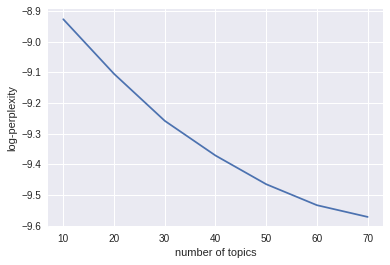

In [38]:
#plot log-perplexity as a function of number of topics

plt.plot(num_topics,log_perplexity)
plt.ylabel('log-perplexity')
plt.xlabel('number of topics')


In [39]:
#visualize the topics from the lowest perplexity model 
min_ind = log_perplexity.index(min(log_perplexity))
min_num_topics = num_topics[min_ind]
print("%i topics resulted in lowest log-perplexity" %min_num_topics)

pprint(lda_models[min_ind].top_topics(corpus_train))



70 topics resulted in lowest log-perplexity
[([(0.073318504, 'photo'),
   (0.038063023, 'mom'),
   (0.03653875, 'mother'),
   (0.030625982, 'baby'),
   (0.029199725, 'day'),
   (0.025923513, 'moment'),
   (0.01711687, 'dad'),
   (0.014729045, 'one'),
   (0.014495596, 'beautiful'),
   (0.012172913, 'good'),
   (0.012158369, 'know'),
   (0.011505451, 'look'),
   (0.011177892, 'time'),
   (0.0106600085, 'parenting'),
   (0.010242692, 'make'),
   (0.009962772, 'video'),
   (0.009798667, 'home'),
   (0.009477988, 'want'),
   (0.009379883, 'see'),
   (0.009311431, 'world')],
  -3.1389490128979505),
 ([(0.10367664, 'love'),
   (0.03536249, 'facebook'),
   (0.027042056, 'learn'),
   (0.024148274, 'red'),
   (0.018235521, 'family'),
   (0.017850325, 'feel'),
   (0.017381135, 'woman'),
   (0.016810145, 'age'),
   (0.016417036, 'date'),
   (0.015399227, 'find'),
   (0.014627026, 'life'),
   (0.014067232, 'man'),
   (0.0139150815, 'husband'),
   (0.012477264, 'day'),
   (0.011578919, 'thing'),
   

In [40]:
#although the log-perplexity is lowest for 70 topics, many seem un-interpretable
#display words for 20 topic model 

pprint(lda_models[1].top_topics(corpus_train))

#here the topics are much more coherent, topics like politics, travel
#health, and fashion are clearly visible

[([(0.024242371, 'style'),
   (0.02015154, 'life'),
   (0.018370429, 'make'),
   (0.017699089, 'get'),
   (0.016266016, 'thing'),
   (0.014852259, 'know'),
   (0.013955147, 'one'),
   (0.013695859, 'good'),
   (0.013685208, 'time'),
   (0.012187837, 'like'),
   (0.01210659, 'feel'),
   (0.011978003, 'want'),
   (0.0118383765, 'sleep'),
   (0.011100759, 'would'),
   (0.010585737, 'take'),
   (0.010463727, 'go'),
   (0.0099740885, 'think'),
   (0.009318306, 'spring'),
   (0.009239014, 'work'),
   (0.008958928, 'people')],
  -3.0808104941153776),
 ([(0.04276896, 'photo'),
   (0.017685939, 'video'),
   (0.017377278, 'wedding'),
   (0.017200375, 'look'),
   (0.012637552, 'day'),
   (0.009627545, 'love'),
   (0.008604587, 'see'),
   (0.008108953, 'make'),
   (0.008000895, 'time'),
   (0.007905287, 'like'),
   (0.0078076036, 'one'),
   (0.007281008, 'home'),
   (0.007142943, 'baby'),
   (0.0067953174, 'kid'),
   (0.0066380613, 'mom'),
   (0.006540424, 'new'),
   (0.006362361, 'take'),
   (0.0

In [ ]:
#visualize the 20 topic model with pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[1], corpus_train, dictionary=dictionary)
vis


In [0]:
## An interesting avenue to explore with this dataset is sentiment analysis. 
## Since all the articles are from The Huffington Post we can compare the sentiment of the 
## headlines from this specific news source to other meida outlets. The dataset 'All the News' 
## located here: https://www.kaggle.com/snapcrack/all-the-news is a collection of headlines and articles 
## from 15 US news sources, Huffington Post not included. We will compare the proportion of 
## positive/neutral/negative headlines to other media outlets. We will use the nltk VADER 
## package to do the sentiment analysis. 


from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()


#read in the headlines from All the News dataset
articles_1 = pd.read_csv('articles1.csv')

#fix headline formatting issue in 1st data file 
articles_1['title'] = articles_1['title'].apply(lambda x: re.sub(" - .*","",x))

#read in 2nd and 3rd data files
articles_2 = pd.read_csv('articles2.csv')
articles_3 = pd.read_csv('articles3.csv')
articles = pd.concat([articles_1,articles_2,articles_3],ignore_index = True)
articles = articles[pd.notnull(articles['title'])]

In [0]:
#apply sentiment analyzer to headlines, we will classify a headline as 
#positive if its compound score is above .3 and negative if its compound score
#is below -.3. See https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk 
#for more information 

#helper function to compute classification for a headline
def classify_headline(analyzer,sentence):
  scores = analyzer.polarity_scores(sentence)
  compound = scores['compound']
  if compound >= .3:
    return 1
  if compound <= -.3:
    return -1
  return 0 

#label articles
articles['labels'] = articles['title'].apply(lambda x: classify_headline(analyzer,x))

In [0]:
#read in Huffington post headline data
articles_hp = []

with open('News_Category_Dataset_v2.json') as f:
    for line in f:
        json_dict = json.loads(line)
        hl = json_dict['headline']
        articles_hp.append(hl)

articles_hp_df = pd.DataFrame(articles_hp,columns = ['titles'])

#apply sentiment classification
articles_hp_df['labels'] = articles_hp_df['titles'].apply(lambda x: classify_headline(analyzer,x))


In [0]:
#calculate proportion of positive/negative/neutral news sources in each data set
n_hp = len(articles_hp_df)

hp_prop_pos = len(articles_hp_df[articles_hp_df['labels'] == 1])/n_hp
hp_prop_neu = len(articles_hp_df[articles_hp_df['labels'] == 0])/n_hp
hp_prop_neg = len(articles_hp_df[articles_hp_df['labels'] == -1])/n_hp

n_all = len(articles)

all_prop_pos = len(articles[articles['labels']==1])/n_all
all_prop_neu = len(articles[articles['labels']==0])/n_all
all_prop_neg = len(articles[articles['labels']==-1])/n_all



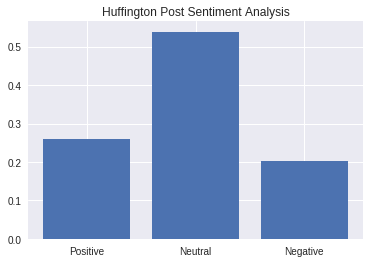

In [46]:
#plot results
plt.bar([1,2,3],[hp_prop_pos,hp_prop_neu,hp_prop_neg],tick_label = ['Positive','Neutral','Negative'],)
plt.title("Huffington Post Sentiment Analysis")
plt.show()

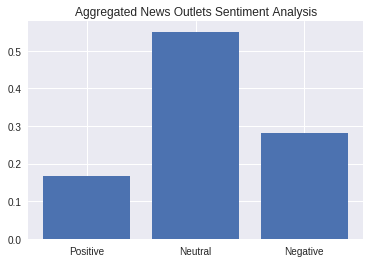

In [47]:
#plot results
plt.bar([1,2,3],[all_prop_pos,all_prop_neu,all_prop_neg],tick_label = ['Positive','Neutral','Negative'])
plt.title("Aggregated News Outlets Sentiment Analysis")
plt.show()